simple training 

In [1]:
from dataloader import WheatOthomapDataset
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torch.nn as nn

# import torchvision.models as models
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights


import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import seaborn as sns


from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
)

annotation_path = "/home/bota/Desktop/active_sensing/src/annotation.txt"
dataset_path = "/media/bota/BOTA/wheat/example-run-001_20241014T1739_ortho_dsm.tif"
tile_ortomappixel_path = "/home/bota/Desktop/active_sensing/data/tomatotiles.txt"

torch.cuda.empty_cache()

In [26]:
class Arguments:

    lr = 5e-6
    n_epochs = 30
    batch_size = 64
    num_workers = 4

    optimizer = "adam"
    metrics = "acc"
    loss = "BCE"
    weight_decay = 1e-7

    n_print_steps = 100
    n_class = 2
    lr_patience = 5
    save_model = True
    exp_dir = f"/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_lr{lr}_bs_{batch_size}_wd{weight_decay}.pth"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


args = Arguments()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Define dataset
all_data = WheatOthomapDataset(dataset_path, annotation_path, tile_ortomappixel_path)


def get_dataloaders(args=args):
    # Define split sizes
    total_size = len(all_data)
    train_size = int(0.7 * total_size)  # 70% for training
    valid_size = int(0.15 * total_size)  # 15% for validation
    test_size = total_size - train_size - valid_size  # Remaining 15% for testing
    print(
        f"Train size: {train_size}, Validation size: {valid_size}, Test size: {test_size}"
    )
    # Split dataset
    train_data, valid_data, test_data = random_split(
        all_data, [train_size, valid_size, test_size]
    )

    # Create DataLoaders
    train_loader = DataLoader(
        train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_data,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_data,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True,
    )
    return train_loader, valid_loader, test_loader

In [28]:
train_loader, valid_loader, test_loader = get_dataloaders(args=args)

Train size: 4620, Validation size: 990, Test size: 990


In [51]:
class ModifiedClassifier(nn.Module):
    def __init__(self, num_classes=2, out_feature=128):
        super(ModifiedClassifier, self).__init__()
        weights = MobileNet_V3_Small_Weights.DEFAULT
        self.backbone = mobilenet_v3_small(weights=weights)
        # self.backbone = models.efficientnet_b0(
        #     pretrained=True
        # )  # Use EfficientNet as feature extractor
        # print(f"original model: {self.backbone}")
        self.backbone.classifier = nn.Sequential(
            nn.Linear(self.backbone.classifier[0].in_features, out_feature),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(out_feature, num_classes),
        )
        # print(f"modified model: {self.backbone}")

    def forward(self, x):
        return self.backbone(x)

In [45]:
model = ModifiedClassifier(num_classes=args.n_class)

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(
                    f"Early stopping triggered. Restoring best model from {self.path}."
                )
                model.load_state_dict(torch.load(self.path))
                return True
        return False

In [32]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots a labeled confusion matrix."""
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [56]:
def evaluate_model_on_test(model, test_loaders):
    model.eval()

    all_preds = []
    all_labels = []
    if isinstance(test_loaders, DataLoader):
        test_loaders = [test_loaders]  # Wrap in a list if it's a single DataLoader

    with torch.no_grad():
        for loader in test_loaders:
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Use sigmoid activation to get probabilities
                probs = torch.sigmoid(outputs)

                # Convert probabilities to class predictions (0 or 1)
                preds = (probs > 0.5).float()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    # Flatten the lists of predictions and labels
    all_preds = np.array(all_preds).reshape(-1, 2)
    all_labels = np.array(all_labels).reshape(-1, 2)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    # print(cm)
    class_names = ["Lodged", "Not lodged"]  # Modify according to your dataset

    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Get the class with the highest probability for each sample
    accuracy = accuracy_score(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    precision = precision_score(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    recall = recall_score(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    f1 = f1_score(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    auc = roc_auc_score(
        all_labels, all_preds
    )  # AUC calculation requires probabilities, not hard predictions

    return accuracy, precision, recall, f1, auc

In [34]:
# # **1. Calculate Class Weights**
# def compute_class_weights(dataset):
#     labels = []
#     for _, label in dataset:
#         labels.append(torch.argmax(label).item())  # Convert one-hot to class index

#     class_counts = np.bincount(labels)
#     total_samples = len(labels)
#     class_weights = total_samples / (len(class_counts) * class_counts)
#     return torch.tensor(class_weights, dtype=torch.float32)


# # Get class weights
# train_dataset = train_loader.dataset  # Replace with actual dataset
# class_weights = compute_class_weights(train_dataset)
# class_weights = class_weights.to("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([2.2190, 0.6454]).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

In [35]:
def train(model, train_loader, valid_loader, args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if args.optimizer == "adam":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    if args.loss == "BCE":
        criterion = nn.BCEWithLogitsLoss(weight=class_weights)
        # criterion = nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights

    early_stopper = EarlyStopping(patience=args.lr_patience, path=args.exp_dir)
    train_losses = []
    val_losses = []
    epochs = []
    for epoch in range(args.n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # print(
        #     f"Epoch {epoch+1}/{args.n_epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(valid_loader):.4f}"
        # )
        train_loss_avg = running_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        epochs.append(epoch + 1)

        clear_output(wait=True)
        plt.clf()
        plt.plot(epochs, train_losses, label="Train Loss", marker="o")
        plt.plot(
            epochs, val_losses, label="Validation Loss", marker="o", linestyle="dashed"
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(
            f"Training Progress | LR: {args.lr} | Batch Size: {args.batch_size} | Weight Decay: {args.weight_decay}"
        )
        plt.legend()
        plt.grid(True)
        display(plt.gcf())

        if early_stopper(
            val_loss,
            model,
        ):
            break  # Stop training if early stopping is triggered

    print("Training complete!")

In [57]:
# load model and test
def test_model(
    model,
    test_loader,
    model_path="/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_auc92.67_lr7.5-06_bs128_wd_0.0025.pth",
):
    # model = ModifiedClassifier(num_classes=args.n_class)
    model.load_state_dict(
        torch.load(
            model_path,
            weights_only=True,
        )
    )
    model = model.to(device)
    # After training your model, evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1, test_auc = (
        evaluate_model_on_test(model, test_loader)
    )

    # Print performance metrics for the test set
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

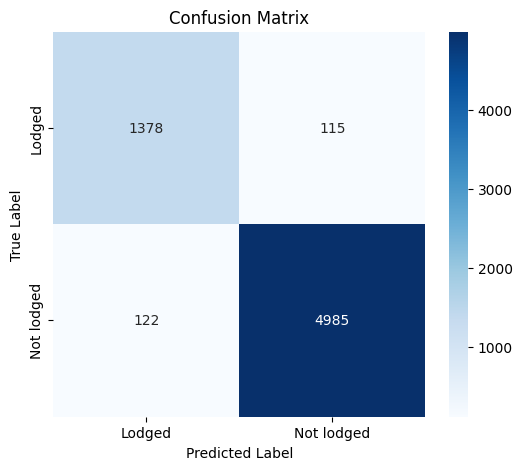

Test Accuracy: 0.9641
Test Precision: 0.9775
Test Recall: 0.9761
Test F1 Score: 0.9768
Test AUC: 0.9457


In [65]:
# with class wieghts
model = ModifiedClassifier(num_classes=args.n_class, out_feature=64)
args.lr = 7.5e-6
args.weight_decay = 1e-7
args.n_epochs = 50
args.batch_size = 128
# train_loader, valid_loader, test_loader = get_dataloaders(args=args)

# train(model, train_loader, valid_loader, args)
test_model(
    model,
    [test_loader, train_loader, valid_loader],
    model_path=args.exp_dir,
)

In [49]:
args.exp_dir

'/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_lr5e-06_bs_64_wd1e-07.pth'

# Test all models

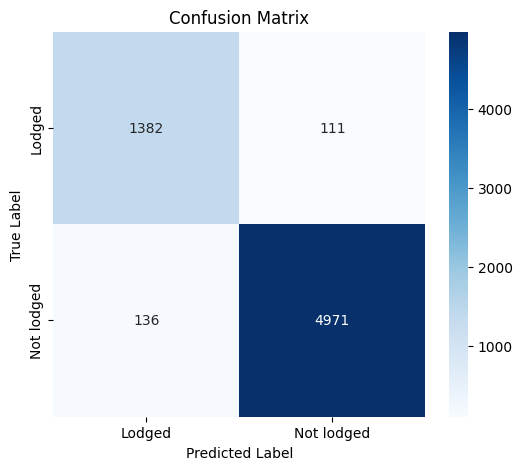

Test Accuracy: 0.9626
Test Precision: 0.9782
Test Recall: 0.9734
Test F1 Score: 0.9758
Test AUC: 0.9489


In [59]:
model = ModifiedClassifier(num_classes=2, out_feature=128)

test_model(
    model,
    [test_loader, train_loader, valid_loader],
    model_path="/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_auc92.67_lr7.5-06_bs128_wd_0.0025.pth",
)

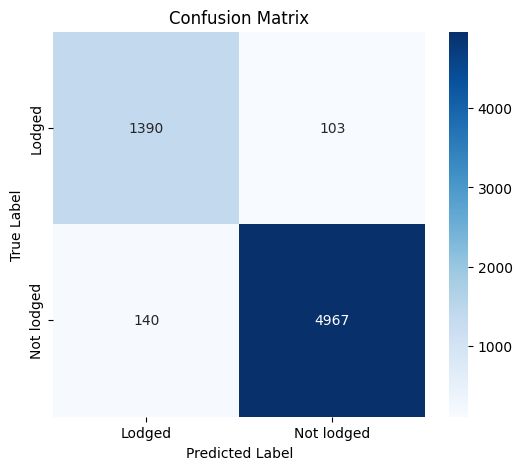

Test Accuracy: 0.9632
Test Precision: 0.9797
Test Recall: 0.9726
Test F1 Score: 0.9761
Test AUC: 0.9507


In [61]:
model = ModifiedClassifier(num_classes=2, out_feature=128)

test_model(
    model,
    [test_loader, train_loader, valid_loader],
    model_path="/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_auc91_lr1_-05_bs128_wd_2.5-04.pth",
)

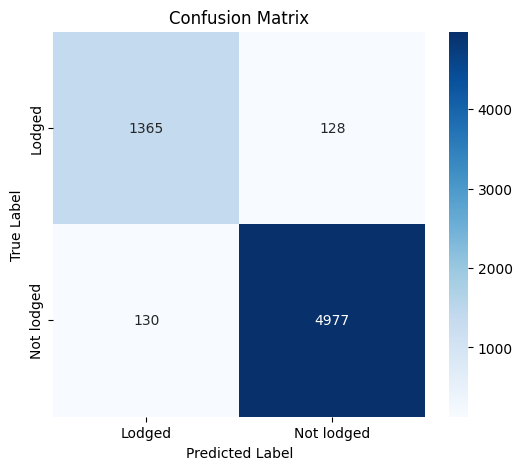

Test Accuracy: 0.9609
Test Precision: 0.9749
Test Recall: 0.9745
Test F1 Score: 0.9747
Test AUC: 0.9413


In [63]:
model = ModifiedClassifier(num_classes=2, out_feature=128)

test_model(
    model,
    [test_loader, train_loader, valid_loader],
    model_path="/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_95_lr7-5-06bs128_wd-07.pth",
)